# Tackling climate crisis with machine learning: Water temperature prediction using 60 years of oceanographic data

Increasing ocean temperatures severely affect marine species and ecosystems. Rising temperatures can contribute to coral bleaching and the loss of breeding grounds for marine fishes and mammals. Machine learning can be useful to predict what contributes to water temperature increase and to mitigate the rising temperatures in a timely fashion.

For this experiment, I used the California Cooperative Oceanic Fisheries Investigations (CalCOFI) dataset that comprises of 60 years of oceanographic data, hosted on Kaggle: https://www.kaggle.com/sohier/calcofi

The CalCOFI data set represents the longest (1949-present) and most complete (more than 50,000 sampling stations) time series of oceanographic and larval fish data in the world. It includes data on temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity. Here I will focus on what predicts water temperature  by using machine learning. Let’s start with importing the libraries and the data!


In [3]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [6]:
dataframe_raw = pd.read_csv('bottle.csv')
dataframe_raw.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dataframe_raw.describe()

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,...,R_CHLA,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1
count,864863.000000,864863.000000,864863.000000,853900.000000,817509.000000,696201.000000,812174.000000,661274.000000,661268.000000,118667.000000,...,225276.000000,225275.000000,864863.000000,122006.000000,1999.000000,224.000000,2084.000000,234.000000,10.000000,84.000000
mean,17138.790958,432432.000000,226.831951,10.799677,33.840350,3.392468,25.819394,57.103779,148.808694,10.497426,...,0.450225,0.198599,228.395694,162.071521,2153.239714,2168.148330,2256.055845,2278.858803,7.948570,7.910983
std,10240.949817,249664.587267,316.050259,4.243825,0.461843,2.073256,1.167787,37.094137,90.187533,6.189688,...,1.208566,0.376539,319.456731,85.722796,112.995202,154.852332,34.844435,58.496495,0.021216,0.077666
min,1.000000,1.000000,0.000000,1.440000,28.431000,-0.010000,20.934000,-0.100000,-0.434900,0.000000,...,-0.010000,-3.890000,0.000000,0.000000,1948.850000,1969.440000,2181.570000,2198.150000,7.923100,7.618300
25%,8269.000000,216216.500000,46.000000,7.680000,33.488000,1.360000,24.965000,21.100000,60.915470,5.000000,...,0.050000,0.050000,46.000000,200.000000,2028.330000,2008.977500,2230.322500,2229.062500,7.931475,7.898675
50%,16848.000000,432432.000000,125.000000,10.060000,33.863000,3.440000,25.996000,54.400000,151.064150,10.000000,...,0.160000,0.110000,126.000000,206.000000,2170.640000,2265.885000,2244.325000,2247.505000,7.946650,7.928850
75%,26557.000000,648647.500000,300.000000,13.880000,34.196900,5.500000,26.646000,97.600000,240.379600,16.000000,...,0.390000,0.230000,302.000000,214.000000,2253.810000,2315.525000,2278.505000,2316.452500,7.963300,7.955100
max,34404.000000,864863.000000,5351.000000,31.140000,37.034000,11.130000,250.784000,214.100000,485.701800,25.000000,...,66.110000,65.300000,5458.000000,424.000000,2367.800000,2364.420000,2434.900000,2437.000000,7.988300,8.047700


I will be focusing on some of the variables for now, so lets slice the dataframe.

In [8]:
calcofi_subset = dataframe_raw.loc[:,'Depthm':'O2Satq']

In [9]:
#let's get the column names
input_cols = list(calcofi_subset.columns.values)
print(input_cols)


['Depthm', 'T_degC', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum', 'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual', 'SThtaq', 'O2Satq']


## Let's see which variables play a more important role in predicting water temperature.

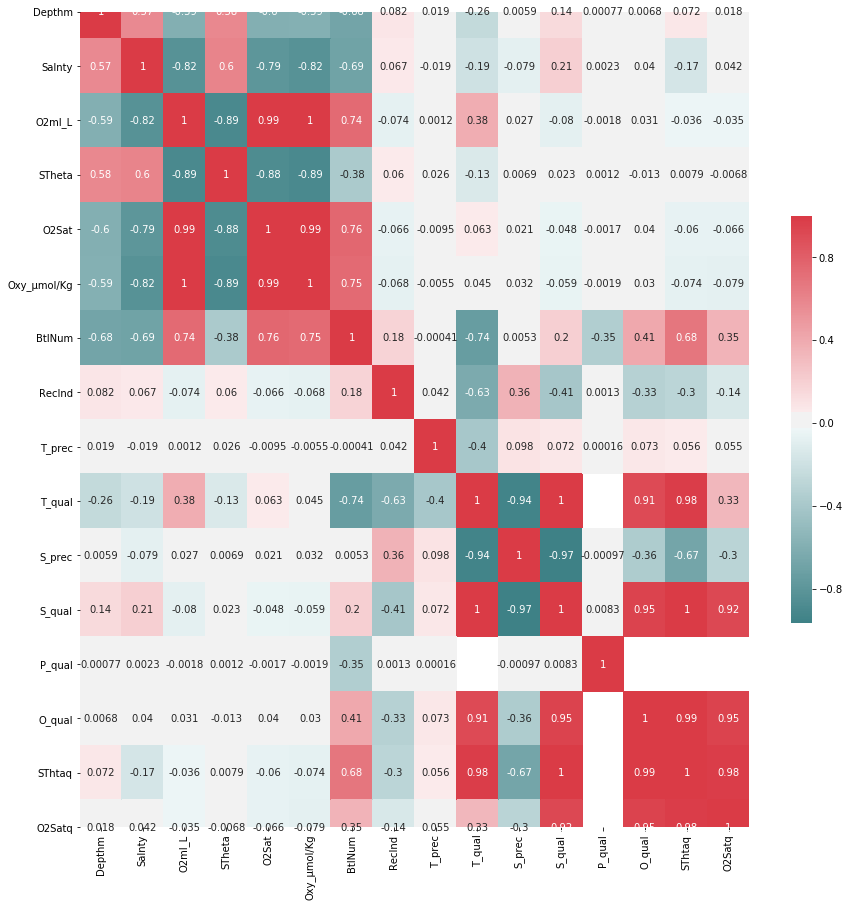

In [11]:
# Compute the correlation matrix
corr = calcofi_subset.drop(['T_degC'], axis=1).corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, cbar_kws={"shrink": .5});

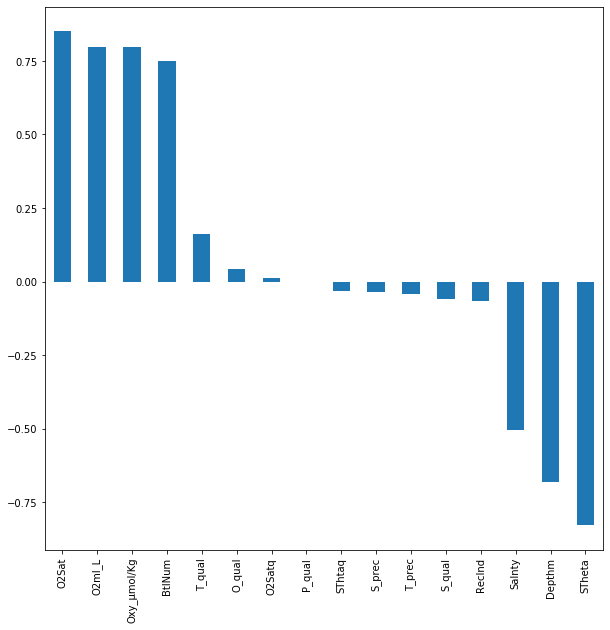

In [26]:
corr_with_temp = calcofi_subset.corr()['T_degC'].sort_values(ascending=False)
plt.figure(figsize=(10,10))
corr_with_isi.drop('T_degC').plot.bar()
plt.show();

We can see that 7 variables seem to correlate better with temperature. Yet, we will remove one of the seven, as it refers to bottle number, and is not an important variable (BtlNum). We will keep 6 parameters in our model and remove the other variables.

* Kept: 'Depthm', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 

* Removed: 'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual', 'SThtaq', 'O2Satq', 'BtlNum'

As you can see, there are 6 columns. Our target variable will be T_degC, which represents water temperature. Rest of the columns will be used for predicting the water temperature (target variable). Therefore, it is multi-various.

## Now we will preprocess the data. First, we start with detecting missing values.

In [46]:
dataframe = calcofi_subset.filter(items=['T_degC', 'Depthm', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg'])
dataframe.isnull().sum()

T_degC          10963
Depthm              0
Salnty          47354
O2ml_L         168662
STheta          52689
O2Sat          203589
Oxy_µmol/Kg    203595
dtype: int64

Looks like we have a lot of missing values. There are different way to address missing values. One way is to fill them with the mean values. First, we need to check how the data is distributed.

Text(0.5, 1.0, 'Fillna with mean')

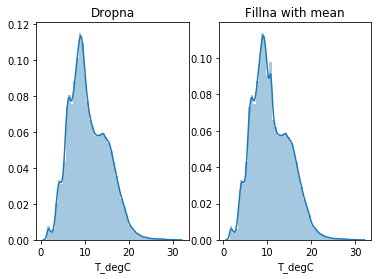

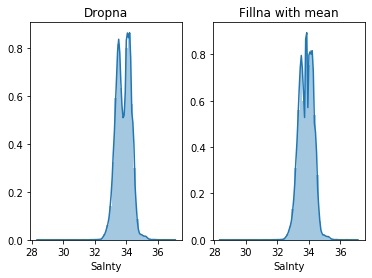

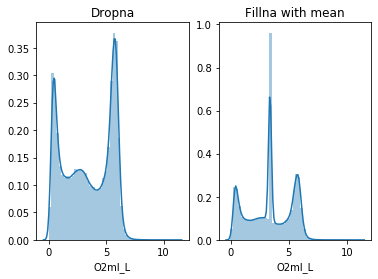

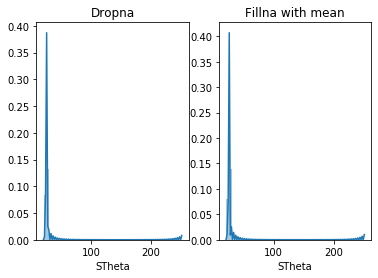

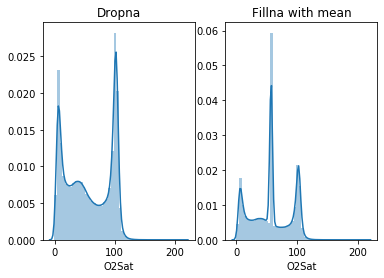

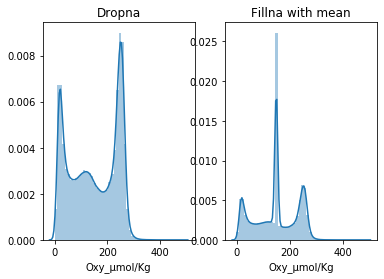

In [47]:
# Let's compare for each variable options fillna() vs mean()
fig, ax=plt.subplots(1,2)
sns.distplot(dataframe.T_degC.dropna(), ax=ax[0])
ax[0].set_title("Dropna")
sns.distplot(dataframe.T_degC.fillna(dataframe.T_degC.mean()), ax=ax[1])
ax[1].set_title("Fillna with mean")

fig, ax=plt.subplots(1,2)
sns.distplot(dataframe.Salnty.dropna(), ax=ax[0])
ax[0].set_title("Dropna")
sns.distplot(dataframe.Salnty.fillna(dataframe.Salnty.mean()), ax=ax[1])
ax[1].set_title("Fillna with mean")

fig, ax=plt.subplots(1,2)
sns.distplot(dataframe.O2ml_L.dropna(), ax=ax[0])
ax[0].set_title("Dropna")
sns.distplot(dataframe.O2ml_L.fillna(dataframe.O2ml_L.mean()), ax=ax[1])
ax[1].set_title("Fillna with mean")

fig, ax=plt.subplots(1,2)
sns.distplot(dataframe.STheta.dropna(), ax=ax[0])
ax[0].set_title("Dropna")
sns.distplot(dataframe.STheta.fillna(dataframe.STheta.mean()), ax=ax[1])
ax[1].set_title("Fillna with mean")

fig, ax=plt.subplots(1,2)
sns.distplot(dataframe.O2Sat.dropna(), ax=ax[0])
ax[0].set_title("Dropna")
sns.distplot(dataframe.O2Sat.fillna(dataframe.O2Sat.mean()), ax=ax[1])
ax[1].set_title("Fillna with mean")

fig, ax=plt.subplots(1,2)
sns.distplot(dataframe['Oxy_µmol/Kg'].dropna(), ax=ax[0])
ax[0].set_title("Dropna")
sns.distplot(dataframe['Oxy_µmol/Kg'].fillna(dataframe['Oxy_µmol/Kg'].mean()), ax=ax[1])
ax[1].set_title("Fillna with mean")

Looks like for O2Sat and Oxy_µmol/Kg, we may want to normalize using .fillna() with mean values rather than .dropna(). For the other variables, there does not seem to be a big difference. In order to standardize, let's replace all missing values with mean values for all seven variables. Finally we can standardize our dataset.

In [48]:
def customize_dataset(data):
    dataframe = data.copy(deep=True)
    #select only 7 variables
    dataframe = dataframe.filter(items=['T_degC', 'Depthm', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg'])
    #fill na values
    dataframe = dataframe.groupby(dataframe.columns, axis = 1).transform(lambda x: x.fillna(x.mean()))
    return dataframe

In [49]:
dataframe = customize_dataset(calcofi_subset)
dataframe.isnull().sum() 

T_degC         0
Depthm         0
Salnty         0
O2ml_L         0
STheta         0
O2Sat          0
Oxy_µmol/Kg    0
dtype: int64

 Perfect! We replaced all NA values with the mean values.

## We can now start building our Machine learning model.
We will create a model with the following steps:
* Prepare the dataset for training
* Create a linear regression model
* Train the model to fit the data
* Make predictions using the trained model

In [53]:
# We will select our input variables, which will be used to predict the water temperature
input_cols = list(dataframe.columns.values)
input_cols.remove('T_degC')
print(input_cols)

#water temperature is our target variable
output_cols = ['T_degC']
print(output_cols)

['Depthm', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg']
['T_degC']


In [69]:
num_cols = dataframe.shape[1]
print(num_cols)

num_rows = len(dataframe)
print(num_rows)

7
864863


minimum water temperature:  T_degC    1.44
dtype: float64
maximum water temperature:  T_degC    31.14
dtype: float64


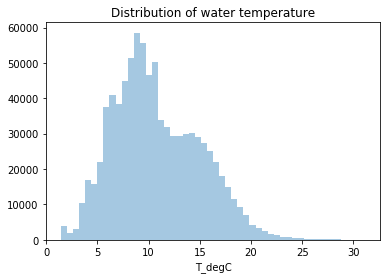

In [132]:
temp_col = dataframe[["T_degC"]]
print("minimum water temperature: ", temp_col.min())
print("maximum water temperature: ", temp_col.max())

plt.title("Distribution of water temperature")

sns.distplot(dataframe.T_degC, kde=False);

If you take a look at the graph, you can see that the distribution is nearly normal. Minimum is 1.44°C and maximum is 31.14°C, which is quite a span. This is why we want to see the relationship of water data (oxygen, saturation, salinity, etc.) and the water temperature as we want to understand which variable has the biggest influence.

In [57]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outputs as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

The previous function converts the pandas Dataframe to Numpy Array. The inputs_array is array of all values of input variables, which are the features we are using to predict target variable (or independent variable), and targets_array is the array of all values of target variable, which is water temperature. Therefore, we transformed data to a suitable format for our machine learning model.

Here is the result:

In [59]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array 

(array([[  0.        ,  33.44      ,   3.39246816,  25.649     ,
          57.10377937, 148.80869412],
        [  8.        ,  33.44      ,   3.39246816,  25.656     ,
          57.10377937, 148.80869412],
        [ 10.        ,  33.437     ,   3.39246816,  25.654     ,
          57.10377937, 148.80869412],
        ...,
        [  5.        ,  33.415     ,   5.796     ,  23.88911   ,
         108.46      , 253.06      ],
        [ 10.        ,  33.4062    ,   5.816     ,  24.01426   ,
         107.74      , 253.92      ],
        [ 15.        ,  33.388     ,   5.774     ,  24.15297   ,
         105.66      , 252.08      ]]), array([[10.5  ],
        [10.46 ],
        [10.46 ],
        ...,
        [18.692],
        [18.161],
        [17.533]]))

The following tensor operation converts the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. In order to standardize, we will set the data type to `torch.float32`.

In [60]:
inputs = torch.from_numpy(inputs_array)
targets = torch.from_numpy(targets_array)
inputs, targets = inputs.type(torch.float32),targets.type(torch.float32)

print(inputs)
print(targets)

tensor([[  0.0000,  33.4400,   3.3925,  25.6490,  57.1038, 148.8087],
        [  8.0000,  33.4400,   3.3925,  25.6560,  57.1038, 148.8087],
        [ 10.0000,  33.4370,   3.3925,  25.6540,  57.1038, 148.8087],
        ...,
        [  5.0000,  33.4150,   5.7960,  23.8891, 108.4600, 253.0600],
        [ 10.0000,  33.4062,   5.8160,  24.0143, 107.7400, 253.9200],
        [ 15.0000,  33.3880,   5.7740,  24.1530, 105.6600, 252.0800]])
tensor([[10.5000],
        [10.4600],
        [10.4600],
        ...,
        [18.6920],
        [18.1610],
        [17.5330]])


In [61]:
#let's check the datatype
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [63]:
dataset = TensorDataset(inputs, targets)

In [64]:
len(dataset)

864863

Now we are going to separate our data into two datasets:

* Train dataset

Literally we are using this dataset to “train” our model. Machine learning model alters its weights and bias based on it (we assume it is linear regression).

* Validation dataset

We use this dataset to actually test if the learning algorithm understands, not memorizing. This simulates how the model will perform in the real world

In [70]:
val_percent = 0.15 
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length
len(train_ds), len(val_ds)

(735134, 129729)

Here, I stated val_percent = 0.15, meaning that I will be using 15% of dataset as validation dataset and 85% of data as training dataset. And I am splitting randomly so that the learning algorithm case can learn unbiased, increasing the chance of better performance.

Finally, we can create data loaders for training & validation.

Here, I am using DataLoader to separate data into batches. Batches group batch_size number element into one group in DataLoader. Additionally, I set shuffle in train_loader as True, meaning that batches will be shuffled, making the training fair and random, which, again, increases the chance of algorithm picking up more efficiently. Here, am using batch size of 32.

In [72]:
batch_size = 32

In [73]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [74]:
# Let's look at a batch of data to verify everything is working fine so far.
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[4.0400e+02, 3.4219e+01, 8.1000e-01, 2.6849e+01, 1.1800e+01, 3.5229e+01],
        [4.0000e+02, 3.4246e+01, 7.1000e-01, 2.6861e+01, 1.0400e+01, 3.0879e+01],
        [3.0000e+02, 3.4164e+01, 1.2500e+00, 2.6735e+01, 1.8500e+01, 5.4371e+01],
        [5.0000e+01, 3.3840e+01, 4.1700e+00, 2.5819e+01, 5.7104e+01, 1.4881e+02],
        [9.3000e+01, 3.3340e+01, 5.1600e+00, 2.5484e+01, 8.2600e+01, 2.2472e+02],
        [2.7000e+01, 3.3390e+01, 5.4000e+00, 2.5241e+01, 8.9300e+01, 2.3523e+02],
        [2.0000e+02, 3.3975e+01, 2.4600e+00, 2.6324e+01, 3.7800e+01, 1.0705e+02],
        [8.0000e+02, 3.4429e+01, 3.7000e-01, 2.7249e+01, 5.2000e+00, 1.6086e+01],
        [3.0000e+01, 3.4510e+01, 4.7700e+00, 2.3479e+01, 9.7700e+01, 2.0814e+02],
        [2.7400e+02, 3.3840e+01, 9.8000e-01, 2.5819e+01, 5.7104e+01, 1.4881e+02],
        [1.0400e+02, 3.3710e+01, 5.0700e+00, 2.5051e+01, 8.7800e+01, 2.2089e+02],
        [7.1000e+01, 3.3165e+01, 5.8700e+00, 2.4610e+01, 1.0150e+02, 2.5586e+02],
        

In [99]:
class WaterTempModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) 
        
    def forward(self, xb):
        out = self.linear(xb)                          
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        loss = F.smooth_l1_loss(out, targets)                        
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out, targets)                           
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

The previous line of functions may look overwhelming but we can break it down. nn.Module indicates that we are extending as Pytorch module. Inside __init__ (initializer) we state self.linear = nn.Linear to use linear modeling of Pytorch. This is essentially a simple linear regression. It is because linear model is simplest and our target variable is continuous variable. Otherwise, it would be a classification problem.

“Forward” function plugs in xb, which is input variable in train dataset, in to linear model and get us the predicted target variable value, which is water temperature, by model.

training_step function returns the calculated loss for each batch. The loss function is specific to the problem, i.e., it can be changed for different datasets and ML problems. Here, I am using Huber loss (smooth Mean Absolute Error) as the loss function. This function is less sensitive to outliers than squared error loss (MSE). I decided to use this loss function based on the quasi-normal distribution of the target variable.

Validation_step function uses validation dataset to assess accuracy model that has been trained using training set. It also returns the result of Huber loss function.

Validation_epoch_end returns the average of validation dataset’s assessment (loss function) then return the average of loss. Here, the setting is 20 epoch, meaning at every 20 iteration (epoch = iteration for training and altering weights and bias), the average will be returned.

Now, lets create Model object:

In [134]:
model = WaterTempModel()

Now, let’s check our default weights and bias. Notice that all parameters has been chose randomly so it will give incorrect result.

In [129]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0056,  1.9033,  0.4780, -2.0788,  0.2667, -0.1061]],
        requires_grad=True), Parameter containing:
 tensor([0.1523], requires_grad=True)]

Those are the parameters of our model. The model in equation can be represented as follows:

y = - 0.2380 x1 + 0.3374 x2 + 0.1023 x3 -0.0871 x4 - 0.2690 x5 -0.2864 x6

where y is water temperature. x1 is water depth in meters, x2 is salinity, x3 is O2 measurements in ml/L, x4 is sigma-theta (density of seawater), x5 is oxygen saturation and x6 is Oxy_µmol/Kg. As you see, salinity has the greatest weight and seawater density has the lowest weight.

Now, to evaluate our model, we will be defining two additional functions as follows:

In [104]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

evaluate function calculates loss function value for each batch of validation dataset (remember that we also partitioned the validation dataset into batches) and returns the average of the loss function in compare to the predicted value. This gives us the final evaluation of our model.

Fit function takes in epoches (# of iteration), learning rate, model, train_loader (train data), val_loader (validation data), opt_function set to the gradient descent, which we talked about previously. This function calculates the minimum point using gradient descent algorithm and every epoch, it returns the result using validation data and evaluate function to return its performance.

Now, this is the result of initial parameter’s performance:

In [105]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result) #a very high loss, does not make sense

{'val_loss': 112.5619888305664}


Around 112 is the score, which is very high! Now using gradient descent, let’s improve.

Here is what it looks like:

In [108]:
epochs = 10
lr1 = 1e-2
lr2 = 1e-3
lr3 = 1e-4
lr4 = 1e-5
lr5 = 1e-6

history1 = fit(epochs, lr1, model, train_loader, val_loader)
history2 = fit(epochs, lr2, model, train_loader, val_loader)
history3 = fit(epochs, lr3, model, train_loader, val_loader)
history4 = fit(epochs, lr4, model, train_loader, val_loader)
history5 = fit(epochs, lr5, model, train_loader, val_loader)

Epoch [10], val_loss: 548.5979
Epoch [10], val_loss: 22.6603
Epoch [10], val_loss: 4.2684
Epoch [10], val_loss: 0.4015
Epoch [10], val_loss: 0.3990


In [109]:
epochs = 10
lr6 = 1e-7
lr7 = 1e-8

history6 = fit(epochs, lr6, model, train_loader, val_loader)
history7 = fit(epochs, lr7, model, train_loader, val_loader)

Epoch [10], val_loss: 0.3987
Epoch [10], val_loss: 0.3986


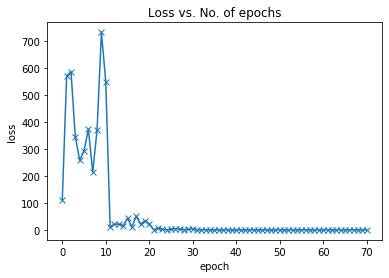

In [110]:
# Replace these values with your results
history = [result] + history1 + history2 + history3 + history4 + history5 + history6 + history7
accuracies = [result['val_loss'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

#looks like we found the optimal loss

From around 112 of error score of default parameter, we brought it down to around 0.4! Now, let’s actually test with some real values!

In [122]:
val_loss = 0.3986

# Let's log the final validation loss to Jovian and commit the notebook
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


## We will now make predictions using the trained model

In [124]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)               
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

## 1st test:

In [125]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([200.0000,  34.1740,   1.6600,  26.5330,  25.3000,  72.2194])
Target: tensor([8.6300])
Prediction: tensor([8.7929])


Around 0.16°C difference, not bad! Looks like the variables we selected can predict the water temperature quite well. 

## 2nd test:

In [126]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([150.0000,  33.7550,   3.6000,  26.0380,  56.1000, 156.6960])
Target: tensor([9.6700])
Prediction: tensor([9.4854])


Around 0.18°C difference, not bad!

## 3rd test:

In [127]:
input, target = val_ds[20]
predict_single(input, target, model)

Input: tensor([125.0000,  33.8000,   3.3925,  26.0060,  57.1038, 148.8087])
Target: tensor([10.0700])
Prediction: tensor([10.7835])



I would like to acknowledge Jovian.ml team (especially Mr. Aakash)!

If you are interested in learning machine learning, check their videos on freecodecamp youtube channel. Learning PyTorch through their material has so far been a fun journey!